In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

In [223]:
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Input, Dense, Lambda, Subtract, Add, Reshape
from tensorflow.keras.models import Model


class NBeatsNet:
    GENERIC_BLOCK = 'generic'
    TREND_BLOCK = 'trend'
    SEASONALITY_BLOCK = 'seasonality'

    _BACKCAST = 'backcast'
    _FORECAST = 'forecast'

    def __init__(self,
                 input_dim=1,
                 exo_dim=0,
                 backcast_length=10,
                 forecast_length=2,
                 stack_types=(TREND_BLOCK, SEASONALITY_BLOCK),
                 nb_blocks_per_stack=3,
                 thetas_dim=(4, 8),
                 share_weights_in_stack=False,
                 hidden_layer_units=256,
                 nb_harmonics=None):

        self.stack_types = stack_types
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.thetas_dim = thetas_dim
        self.units = hidden_layer_units
        self.share_weights_in_stack = share_weights_in_stack
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.input_dim = input_dim
        self.exo_dim = exo_dim
        self.input_shape = (self.backcast_length, self.input_dim)
        self.exo_shape = (self.backcast_length, self.exo_dim)
        self.output_shape = (self.forecast_length, self.input_dim)
        self.weights = {}
        self.nb_harmonics = nb_harmonics
        assert len(self.stack_types) == len(self.thetas_dim)

        x = Input(shape=self.input_shape, name='input_variable')
        x_ = {}
        for k in range(self.input_dim):
            x_[k] = Lambda(lambda z: z[..., k])(x)
        e_ = {}
        if self.has_exog():
            e = Input(shape=self.exo_shape, name='exos_variables')
            for k in range(self.exo_dim):
                e_[k] = Lambda(lambda z: z[..., k])(e)
        else:
            e = None
        y_ = {}

        for stack_id in range(len(self.stack_types)):
            stack_type = self.stack_types[stack_id]
            nb_poly = self.thetas_dim[stack_id]
            for block_id in range(self.nb_blocks_per_stack):
                backcast, forecast = self.create_block(x_, e_, stack_id, block_id, stack_type, nb_poly)
                for k in range(self.input_dim):
                    x_[k] = Subtract()([x_[k], backcast[k]])
                    if stack_id == 0 and block_id == 0:
                        y_[k] = forecast[k]
                    else:
                        y_[k] = Add()([y_[k], forecast[k]])

        for k in range(self.input_dim):
            y_[k] = Reshape(target_shape=(self.forecast_length, 1))(y_[k])
            x_[k] = Reshape(target_shape=(self.backcast_length, 1))(x_[k])
        if self.input_dim > 1:
            y_ = Concatenate()([y_[ll] for ll in range(self.input_dim)])
            x_ = Concatenate()([x_[ll] for ll in range(self.input_dim)])
        else:
            y_ = y_[0]
            x_ = x_[0]

        if self.has_exog():
            n_beats_forecast = Model([x, e], y_, name=self._FORECAST)
            n_beats_backcast = Model([x, e], x_, name=self._BACKCAST)
        else:
            n_beats_forecast = Model(x, y_, name=self._FORECAST)
            n_beats_backcast = Model(x, x_, name=self._BACKCAST)

        self.models = {model.name: model for model in [n_beats_backcast, n_beats_forecast]}
        self.cast_type = self._FORECAST

    def has_exog(self):
        # exo/exog is short for 'exogenous variable', i.e. any input
        # features other than the target time-series itself.
        return self.exo_dim > 0

    @staticmethod
    def load(filepath, custom_objects=None, compile=True):
        from tensorflow.keras.models import load_model
        return load_model(filepath, custom_objects, compile)

    def _r(self, layer_with_weights, stack_id):
        # mechanism to restore weights when block share the same weights.
        # only useful when share_weights_in_stack=True.
        if self.share_weights_in_stack:
            layer_name = layer_with_weights.name.split('/')[-1]
            try:
                reused_weights = self.weights[stack_id][layer_name]
                return reused_weights
            except KeyError:
                pass
            if stack_id not in self.weights:
                self.weights[stack_id] = {}
            self.weights[stack_id][layer_name] = layer_with_weights
        return layer_with_weights

    def create_block(self, x, e, stack_id, block_id, stack_type, nb_poly):
        # register weights (useful when share_weights_in_stack=True)
        def reg(layer):
            return self._r(layer, stack_id)

        # update name (useful when share_weights_in_stack=True)
        def n(layer_name):
            return '/'.join([str(stack_id), str(block_id), stack_type, layer_name])

        backcast_ = {}
        forecast_ = {}
        d1 = reg(Dense(self.units, activation='relu', name=n('d1')))
        d2 = reg(Dense(self.units, activation='relu', name=n('d2')))
        d3 = reg(Dense(self.units, activation='relu', name=n('d3')))
        d4 = reg(Dense(self.units, activation='relu', name=n('d4')))
        if stack_type == 'generic':
            theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = reg(Dense(self.backcast_length, activation='linear', name=n('backcast')))
            forecast = reg(Dense(self.forecast_length, activation='linear', name=n('forecast')))
        elif stack_type == 'trend':
            theta_f = theta_b = reg(Dense(nb_poly, activation='linear', use_bias=False, name=n('theta_f_b')))
            backcast = Lambda(trend_model, arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
            forecast = Lambda(trend_model, arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                                      'forecast_length': self.forecast_length})
        else:  # 'seasonality'
            if self.nb_harmonics:
                theta_b = reg(Dense(self.nb_harmonics, activation='linear', use_bias=False, name=n('theta_b')))
            else:
                theta_b = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_b')))
            theta_f = reg(Dense(self.forecast_length, activation='linear', use_bias=False, name=n('theta_f')))
            backcast = Lambda(seasonality_model,
                              arguments={'is_forecast': False, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
            forecast = Lambda(seasonality_model,
                              arguments={'is_forecast': True, 'backcast_length': self.backcast_length,
                                         'forecast_length': self.forecast_length})
        for k in range(self.input_dim):
            if self.has_exog():
                d0 = Concatenate()([x[k]] + [e[ll] for ll in range(self.exo_dim)])
            else:
                d0 = x[k]
            d1_ = d1(d0)
            d2_ = d2(d1_)
            d3_ = d3(d2_)
            d4_ = d4(d3_)
            theta_f_ = theta_f(d4_)
            theta_b_ = theta_b(d4_)
            backcast_[k] = backcast(theta_b_)
            forecast_[k] = forecast(theta_f_)

        return backcast_, forecast_

    def __getattr__(self, name):
        # https://github.com/faif/python-patterns
        # model.predict() instead of model.n_beats.predict()
        # same for fit(), train_on_batch()...
        attr = getattr(self.models[self._FORECAST], name)

        if not callable(attr):
            return attr

        def wrapper(*args, **kwargs):
            cast_type = self._FORECAST
            if attr.__name__ == 'predict' and 'return_backcast' in kwargs and kwargs['return_backcast']:
                del kwargs['return_backcast']
                cast_type = self._BACKCAST
            return getattr(self.models[cast_type], attr.__name__)(*args, **kwargs)

        return wrapper


def linear_space(backcast_length, forecast_length, is_forecast=True):
    ls = K.arange(-float(backcast_length), float(forecast_length), 1) / forecast_length
    return ls[backcast_length:] if is_forecast else K.abs(K.reverse(ls[:backcast_length], axes=0))


def seasonality_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.get_shape().as_list()[-1]
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    s1 = K.stack([K.cos(2 * np.pi * i * t) for i in range(p1)])
    s2 = K.stack([K.sin(2 * np.pi * i * t) for i in range(p2)])
    if p == 1:
        s = s2
    else:
        s = K.concatenate([s1, s2], axis=0)
    s = K.cast(s, np.float32)
    return K.dot(thetas, s)


def trend_model(thetas, backcast_length, forecast_length, is_forecast):
    p = thetas.shape[-1]
    t = linear_space(backcast_length, forecast_length, is_forecast=is_forecast)
    t = K.transpose(K.stack([t ** i for i in range(p)]))
    t = K.cast(t, np.float32)
    return K.dot(thetas, K.transpose(t))

In [133]:
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, EasterMonday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

class FrBusinessCalendar(AbstractHolidayCalendar):
    """ Custom Holiday calendar for France based on
        https://en.wikipedia.org/wiki/Public_holidays_in_France
      - 1 January: New Year's Day
      - Moveable: Easter Monday (Monday after Easter Sunday)
      - 1 May: Labour Day
      - 8 May: Victory in Europe Day
      - Moveable Ascension Day (Thursday, 39 days after Easter Sunday)
      - 14 July: Bastille Day
      - 15 August: Assumption of Mary to Heaven
      - 1 November: All Saints' Day
      - 11 November: Armistice Day
      - 25 December: Christmas Day
    """
    rules = [
        Holiday('New Years Day', month=1, day=1),
        EasterMonday,
        Holiday('Labour Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption of Mary to Heaven', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas Day', month=12, day=25)
    ]
    
holidays = FrBusinessCalendar().holidays(start=df.date.min(), end=df.date.max())

In [134]:
import numpy as np

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [319]:
df = pd.read_excel('/workdir/src/sncfisajoke_user_tweets.xlsx')

months_to_number = {
    'janvier': '01',
    'février': '02',
    'mars': '03',
    'avril': '04',
    'mai': '05',
    'juin': '06',
    'juillet': '07',
    'août': '08',
    'septembre': '09',
    'octobre' : '10', 
    'novembre' : '11',
    'décembre' : '12',
}
df['text_process'] = df['Text'].apply(lambda x: x.split(' ')[0])
df = df.loc[df['text_process'] == 'Le']


def clean_from_text(df):
    dates, list_nbr_travels, list_nbr_late_trains = [], [], []
    for i, row in df.iterrows():
        data = row['Text'].split('\n')
        day, month, year = data[0].split(' ')[2:-1]
        nbr_travels = data[1].split(' : ')[-1]
        nbr_late_trains = data[2].split(' ')[-2]
        
        dates.append(day+'-'+months_to_number[month]+'-'+year)
        list_nbr_travels.append(nbr_travels)
        list_nbr_late_trains.append(nbr_late_trains)
    
    df['date'] = dates
    df['nbr_travels'] = list_nbr_travels
    df['nbr_late_trains'] = list_nbr_late_trains

    return df[['date', 'nbr_travels', 'nbr_late_trains']]

df = clean_from_text(df)



In [320]:
df['date'] = pd.to_datetime(df['date'],format='%d-%m-%Y')
df = df.sort_values('date', ascending=True)

In [321]:
def add_features(df):
    df['is_weekend'] = ((pd.DatetimeIndex(df['date']).dayofweek) // 5 == 1).astype(int)
    df['is_holiday'] = np.where(df['date'].isin(holidays), 1, 0)
    df['is_working_day'] = np.where((df['is_weekend']==1) | (df['is_holiday']==1), 0, 1)
    df['day_of_month'] = df['date'].dt.strftime("%d").astype(int) 
    df['day_of_week'] = df['date'].dt.strftime("%w").astype(int)
    df['day_of_year'] = df['date'].dt.strftime("%j").astype(int)
    df['week'] = df['date'].dt.strftime("%W").astype(int)
    df['month'] = df['date'].dt.strftime("%m").astype(int)
    df['year'] = df['date'].dt.strftime("%Y").astype(int)
    df['year_month'] = df['date'].dt.strftime("%Y%m").astype(int)
    df['quarter'] = df['date'].dt.quarter.astype(int)
    df['day_of_month_cos'] = df['day_of_month'].apply(lambda x: np.cos(np.pi*2*x/31))
    df['day_of_month_sin'] = df['day_of_month'].apply(lambda x: np.sin(np.pi*2*x/31))

    df['month_cos'] = df['month'].apply(lambda x: np.cos(np.pi*2*x/12))

    df['month_sin'] = df['month'].apply(lambda x: np.sin(np.pi*2*x/12))
    
    df['nbr_travels'] = df['nbr_travels'].astype(int)
    df['nbr_late_trains'] = df['nbr_late_trains'].astype(int)


    print(df)
add_features(df)

           date  nbr_travels  nbr_late_trains  is_weekend  is_holiday  \
3198 2019-03-01        18680             1799           0           0   
3195 2019-03-02        12341             1049           1           0   
3192 2019-03-03        10839              969           1           0   
3185 2019-03-04        18502             2228           0           0   
3182 2019-03-05        18373             1767           0           0   
...         ...          ...              ...         ...         ...   
17   2021-08-21        12530              991           1           0   
14   2021-08-22        11335              892           1           0   
8    2021-08-23        18133             1528           0           0   
5    2021-08-24        18035             1517           0           0   
2    2021-08-25        12460             1714           0           0   

      is_working_day  day_of_month  day_of_week  day_of_year  week  month  \
3198               1             1            

In [274]:
#df.plot.scatter('day_of_month_cos', 'day_of_month_sin').set_aspect('equal')

In [322]:
#df_tmp = df.set_index('date')
#df_tmp['nbr_travels'].astype(int).plot(figsize=(25,7))

In [323]:
def build_time_series(array: np.ndarray, window_size: int, forecast_size: int):
    list_x, list_y = [], []
    for i in range(0, len(array) - forecast_size - window_size + 1):
        x = array[i: i + window_size, :]
        y = array[i + window_size: i + window_size + forecast_size, 0]
        list_x.append(x)
        list_y.append(y)

    return np.array(list_x), np.array(list_y)

In [324]:
x = df.drop(['date', 'nbr_late_trains'], axis=1).values

In [303]:
y_test = x[-7:, 0]
y_test
x_test = x[-7-30:-7, :]
x_test

array([[ 1.76470000e+04,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  2.00000000e+01,  2.00000000e+00,
         2.01000000e+02,  2.90000000e+01,  7.00000000e+00,
         2.02100000e+03,  2.02107000e+05,  3.00000000e+00,
        -6.12105983e-01, -7.90775737e-01, -8.66025404e-01,
        -5.00000000e-01],
       [ 1.74610000e+04,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  2.10000000e+01,  3.00000000e+00,
         2.02000000e+02,  2.90000000e+01,  7.00000000e+00,
         2.02100000e+03,  2.02107000e+05,  3.00000000e+00,
        -4.40394152e-01, -8.97804540e-01, -8.66025404e-01,
        -5.00000000e-01],
       [ 1.75510000e+04,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  2.20000000e+01,  4.00000000e+00,
         2.03000000e+02,  2.90000000e+01,  7.00000000e+00,
         2.02100000e+03,  2.02107000e+05,  3.00000000e+00,
        -2.50652532e-01, -9.68077119e-01, -8.66025404e-01,
        -5.00000000e-01],
       [ 1.78350000e+04,  0.00000000e

In [305]:
x[-1]

array([ 1.24600000e+04,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        2.50000000e+01,  3.00000000e+00,  2.37000000e+02,  3.40000000e+01,
        8.00000000e+00,  2.02100000e+03,  2.02108000e+05,  3.00000000e+00,
        3.47305253e-01, -9.37752132e-01, -5.00000000e-01, -8.66025404e-01])

In [306]:
X, Y = build_time_series(x, 30, 7)

In [165]:
tscv = TimeSeriesSplit(gap=5 - 1, n_splits=5, test_size=1)

<AxesSubplot:>

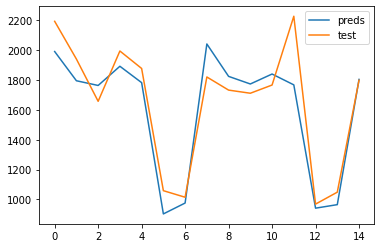

In [167]:
tmp = pd.DataFrame()
tmp['preds'] = preds[0]
tmp['test'] = y_test[0]

tmp.plot()

In [176]:
import tensorflow as tf
from tensorflow import keras


(850, 30, 16)

In [213]:
def deeper_conv2D(n_filters, fsize, window_size, n_features):
    new_model = keras.Sequential()
    new_model.add(tf.keras.layers.Conv2D(n_filters, (4, 1), 
                                         padding='same', 
                                         activation='relu', 
                                         input_shape=(window_size, n_features, 1)))
    #new_model.add(tf.keras.layers.Conv2D(n_filters, (5, 1), 
    #                                     padding='same', 
    #                                     activation='relu'))
    new_model.add(tf.keras.layers.Flatten())
    new_model.add(tf.keras.layers.Dense(1000, activation='relu'))
    new_model.add(tf.keras.layers.Dense(100))
    new_model.add(tf.keras.layers.Dense(7))
    new_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return new_model

In [214]:
model = deeper_conv2D(64, 5, 30, 16)
model.fit(np.expand_dims(X, 3), Y, batch_size=32, epochs=20)

Epoch 1/20
27/27 [==============================] - 5s 161ms/step - loss: 607530240.0000 - mae: 11116.8154
Epoch 2/20
27/27 [==============================] - 4s 160ms/step - loss: 16509502.0000 - mae: 3503.2878
Epoch 3/20
27/27 [==============================] - 4s 161ms/step - loss: 14060902.0000 - mae: 3307.2932
Epoch 4/20
27/27 [==============================] - 4s 162ms/step - loss: 12731281.0000 - mae: 3147.3462
Epoch 5/20
27/27 [==============================] - 4s 166ms/step - loss: 11414837.0000 - mae: 2983.4863
Epoch 6/20
27/27 [==============================] - 4s 162ms/step - loss: 10479314.0000 - mae: 2795.8354
Epoch 7/20
27/27 [==============================] - 4s 161ms/step - loss: 9063673.0000 - mae: 2560.9114
Epoch 8/20
27/27 [==============================] - 4s 160ms/step - loss: 8121783.0000 - mae: 2364.9036
Epoch 9/20
27/27 [==============================] - 4s 164ms/step - loss: 7193483.5000 - mae: 2190.7729
Epoch 10/20
27/27 [==============================] - 4s 

In [261]:
num_samples, time_steps, input_dim, output_dim = 50_000, 30, 16, 7
model_keras = NBeatsNet(
    backcast_length=time_steps, 
    forecast_length=output_dim, 
    input_dim=1,
    exo_dim=15,
    stack_types=(NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
    nb_blocks_per_stack=2, 
    thetas_dim=(4, 4), 
    share_weights_in_stack=True,
    hidden_layer_units=64)

model_keras.compile(loss='mae', optimizer='adam')


"""# Definition of the data. The problem to solve is to find f such as | f(x) - y | -> 0.
# where f = np.mean.
x = np.random.uniform(size=(num_samples, time_steps, input_dim))
y = np.mean(x, axis=1, keepdims=True)
print(x.shape)
# Split data into training and testing datasets.
c = num_samples // 10
x_train, y_train, x_test, y_test = x[c:], y[c:], x[:c], y[:c]
test_size = len(x_test)

# Train the model.
print('Keras training...')"""


"# Definition of the data. The problem to solve is to find f such as | f(x) - y | -> 0.\n# where f = np.mean.\nx = np.random.uniform(size=(num_samples, time_steps, input_dim))\ny = np.mean(x, axis=1, keepdims=True)\nprint(x.shape)\n# Split data into training and testing datasets.\nc = num_samples // 10\nx_train, y_train, x_test, y_test = x[c:], y[c:], x[:c], y[:c]\ntest_size = len(x_test)\n\n# Train the model.\nprint('Keras training...')"

In [307]:
for train_index, test_index in tscv.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]
    '''model = RandomForestRegressor()
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    preds = model.predict(X_test.reshape(X_test.shape[0], -1))
    print(preds.shape)
    print(y_test.shape)
    
    print(mae(y_test, preds))
    print(mape(y_test, preds))'''
    model_keras = NBeatsNet(
    backcast_length=time_steps, 
    forecast_length=output_dim, 
    input_dim=1,
    exo_dim=15,
    stack_types=(NBeatsNet.TREND_BLOCK, NBeatsNet.SEASONALITY_BLOCK),
    nb_blocks_per_stack=2, 
    thetas_dim=(4, 4), 
    share_weights_in_stack=True,
    hidden_layer_units=256)

    model_keras.compile(loss='mae', optimizer='adam')
    
    end_train = X_train[:,:,0]
    exo_train = X_train[:,:, 1:]
    
    end_val = X_val[:,:,0]
    exo_val = X_val[:,:, 1:]
    
    model_keras.fit(
        (end_train, exo_train), 
        y_train, 
        validation_data=((end_val, exo_val), y_val),
        epochs=100, 
        batch_size=32
    )
    
    break

Epoch 1/100
27/27 [==============================] - 2s 20ms/step - loss: 45377.8008 - val_loss: 3740.6145
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 2867.8169 - val_loss: 2756.0955
Epoch 3/100
27/27 [==============================] - 0s 9ms/step - loss: 1905.1741 - val_loss: 2356.8086
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 1606.6307 - val_loss: 3124.2537
Epoch 5/100
27/27 [==============================] - 0s 8ms/step - loss: 1545.1110 - val_loss: 2537.9934
Epoch 6/100
27/27 [==============================] - 0s 9ms/step - loss: 1552.1219 - val_loss: 2409.8884
Epoch 7/100
27/27 [==============================] - 0s 8ms/step - loss: 1708.6992 - val_loss: 2187.5112
Epoch 8/100
27/27 [==============================] - 0s 8ms/step - loss: 1530.2357 - val_loss: 2216.7729
Epoch 9/100
27/27 [==============================] - 0s 8ms/step - loss: 1557.4930 - val_loss: 2148.2263
Epoch 10/100
27/27 [==============================] 

27/27 [==============================] - 0s 9ms/step - loss: 782.4686 - val_loss: 2083.0813
Epoch 79/100
27/27 [==============================] - 0s 8ms/step - loss: 813.6705 - val_loss: 2104.1033
Epoch 80/100
27/27 [==============================] - 0s 8ms/step - loss: 883.0869 - val_loss: 2015.4379
Epoch 81/100
27/27 [==============================] - 0s 9ms/step - loss: 819.1296 - val_loss: 2182.6345
Epoch 82/100
27/27 [==============================] - 0s 9ms/step - loss: 816.5103 - val_loss: 1985.9553
Epoch 83/100
27/27 [==============================] - 0s 8ms/step - loss: 782.6423 - val_loss: 1933.1407
Epoch 84/100
27/27 [==============================] - 0s 8ms/step - loss: 807.7625 - val_loss: 1959.0604
Epoch 85/100
27/27 [==============================] - 0s 8ms/step - loss: 850.6459 - val_loss: 2095.1665
Epoch 86/100
27/27 [==============================] - 0s 8ms/step - loss: 836.1191 - val_loss: 2115.6331
Epoch 87/100
27/27 [==============================] - 0s 9ms/step - 

In [318]:
model_keras.predict((x_test[:, 0], x_test[:, 1:]))

ValueError: in user code:

    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.8/dist-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 1 is incompatible with layer forecast: expected shape=(None, 30, 15), found shape=(None, 15)


In [317]:
x_test[:, 0].shape

(30,)

In [328]:
X, Y = build_time_series(x, 30, 7)
tscv = TimeSeriesSplit(gap=5 - 1, n_splits=5, test_size=1)
for train_index, test_index in tscv.split(X):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = Y[train_index], Y[test_index]
    model = RandomForestRegressor()
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    preds = model.predict(X_test.reshape(X_test.shape[0], -1))
    
    print('MAE :', round(mae(y_val, preds), 0))
    print('MAPE : ', round(mape(y_val, preds), 2), '%')

MAE : 3299.0
MAPE :  23.01 %
MAE : 3871.0
MAPE :  28.13 %
MAE : 3210.0
MAPE :  23.1 %
MAE : 2325.0
MAPE :  15.57 %
MAE : 3150.0
MAPE :  20.33 %


<AxesSubplot:>

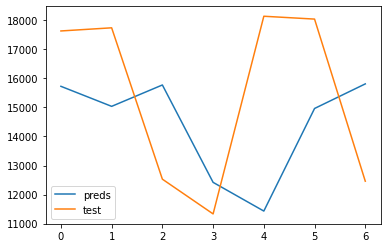

In [329]:
tmp = pd.DataFrame()
tmp['preds'] = preds[0]
tmp['test'] = y_val[0]

tmp.plot()